#  Прогнозирование заказов такси

Условная компания агрегатор такси собрала исторические данные о заказах в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо спрогнозировать количество заказов такси на следующий час. 

In [1]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np 
import time
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from catboost import CatBoostRegressor, Pool

from lightgbm import LGBMRegressor

from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

STATE = 12345
TEST_SIZE = 0.1

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv')
except:
    df = pd.read_csv('taxi.csv')

In [4]:
def review(df): 
    """функция для отображения общей информации"""
    info = display(df.head(10)), df.info(), display(df.describe()) 

In [5]:
def show_hist(df):
    """функция для построения гистограммы"""
    df.plot(figsize=(15,5))
    plt.show()

In [120]:
def visual_of_predictions(target_test, target_predict):
    """функция для построения гистограммы предсказаний"""
    a=np.array(target_test, np.int32)
    b=np.array(target_predict, np.int32)
    
    plt.figure(figsize=(15,5))
    plt.plot(a, color = 'red', label = 'Historical data')
    plt.plot(b, color = 'blue', label='Predicted data')
    plt.legend()
    plt.show()

## Подготовка

Посмотрим на общую информацию

In [6]:
review(df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Проверим пропущенные значения и дубликаты

In [7]:
(df.isna().mean() * 100).round(2)

datetime      0.0
num_orders    0.0
dtype: float64

In [8]:
if df.duplicated().sum() == 0:
    print('Дубликатов не обнаружено')
else:
    print('Дубликатов найдено: {}'.format(df.duplicated().sum()))

Дубликатов не обнаружено


Приведем столбец `datetime` к типу данных `datetime`

In [9]:
df['datetime'] = pd.to_datetime(df['datetime'],format = '%Y-%m-%d %H:%M:%S')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Проверим период собранных данных

In [11]:
df['datetime'].min()

Timestamp('2018-03-01 00:00:00')

In [12]:
df['datetime'].max()

Timestamp('2018-08-31 23:50:00')

Установим индекс таблицы равным столбцу `datetime`

In [13]:
df = df.set_index('datetime')

In [14]:
review(df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Отсортируем индекс таблицы

In [15]:
df = df.sort_index()

In [16]:
df.index.is_monotonic

True

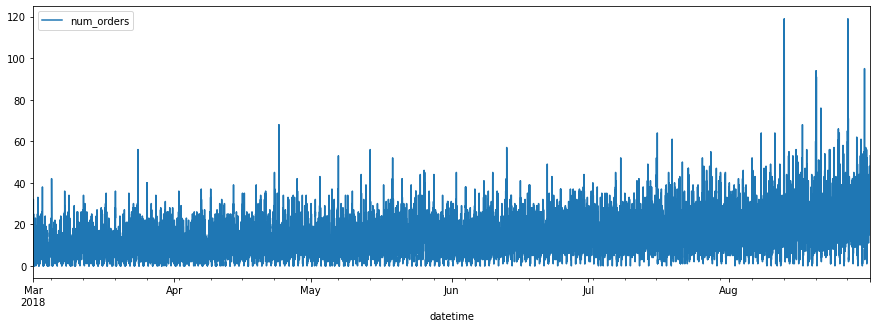

In [17]:
show_hist(df)

Вероятно данные собраны с периодичностью в 10 минут - выполним рессемплирование по одному часу.

In [18]:
df = df.resample('1H').sum()

Снизим колебания временного ряда

In [19]:
df["rolling_mean"] = df["num_orders"].rolling(15).mean()

### Вывод

- тип данных столбца `datetime` приведен к типу `datetime64[ns]`;
- данные чистые - не содержат пропущенных значений и дубликатов;
- набор данных показывает данные о заказах в период с `2018-03-01 00:00:00` по `2018-08-31 23:50:00`;
- выполнено ресемплирование по одному часу;
- выполнено сглаживание временного ряда методом скользящего среднего. 

## Анализ

Посмотрим на тренды и сезонность

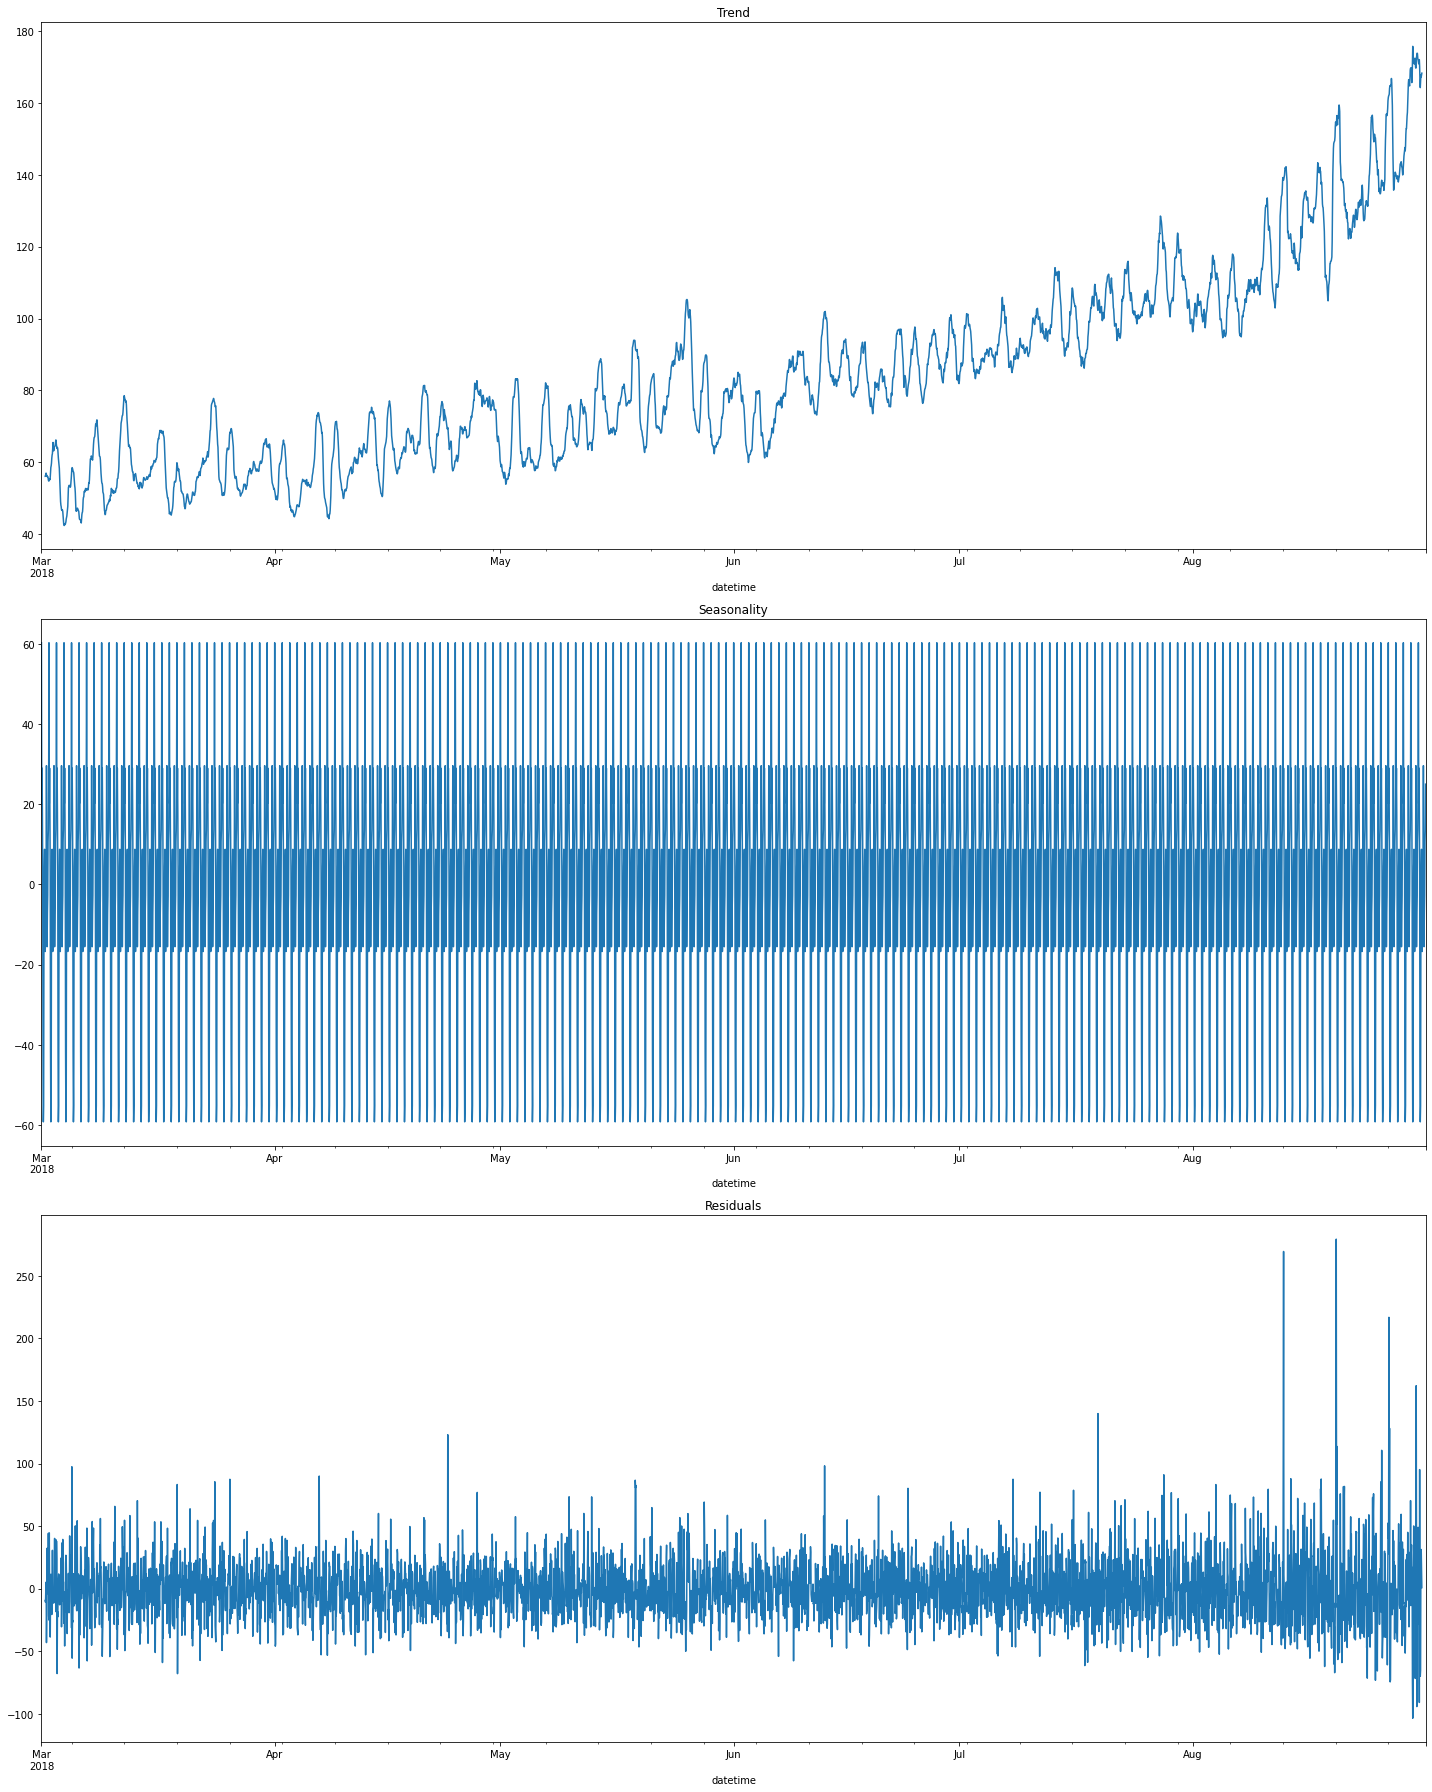

In [20]:
decomposed = seasonal_decompose(df['num_orders']) 

plt.figure(figsize=(20,25))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Графики показывают, что с мая идет плавное изменение среднего значения ряда. Сезонность же остается неизменной на протяжении всего исследуемого периода. Рассмотрим более подробно в разрезе недель в течении двух месяцев.

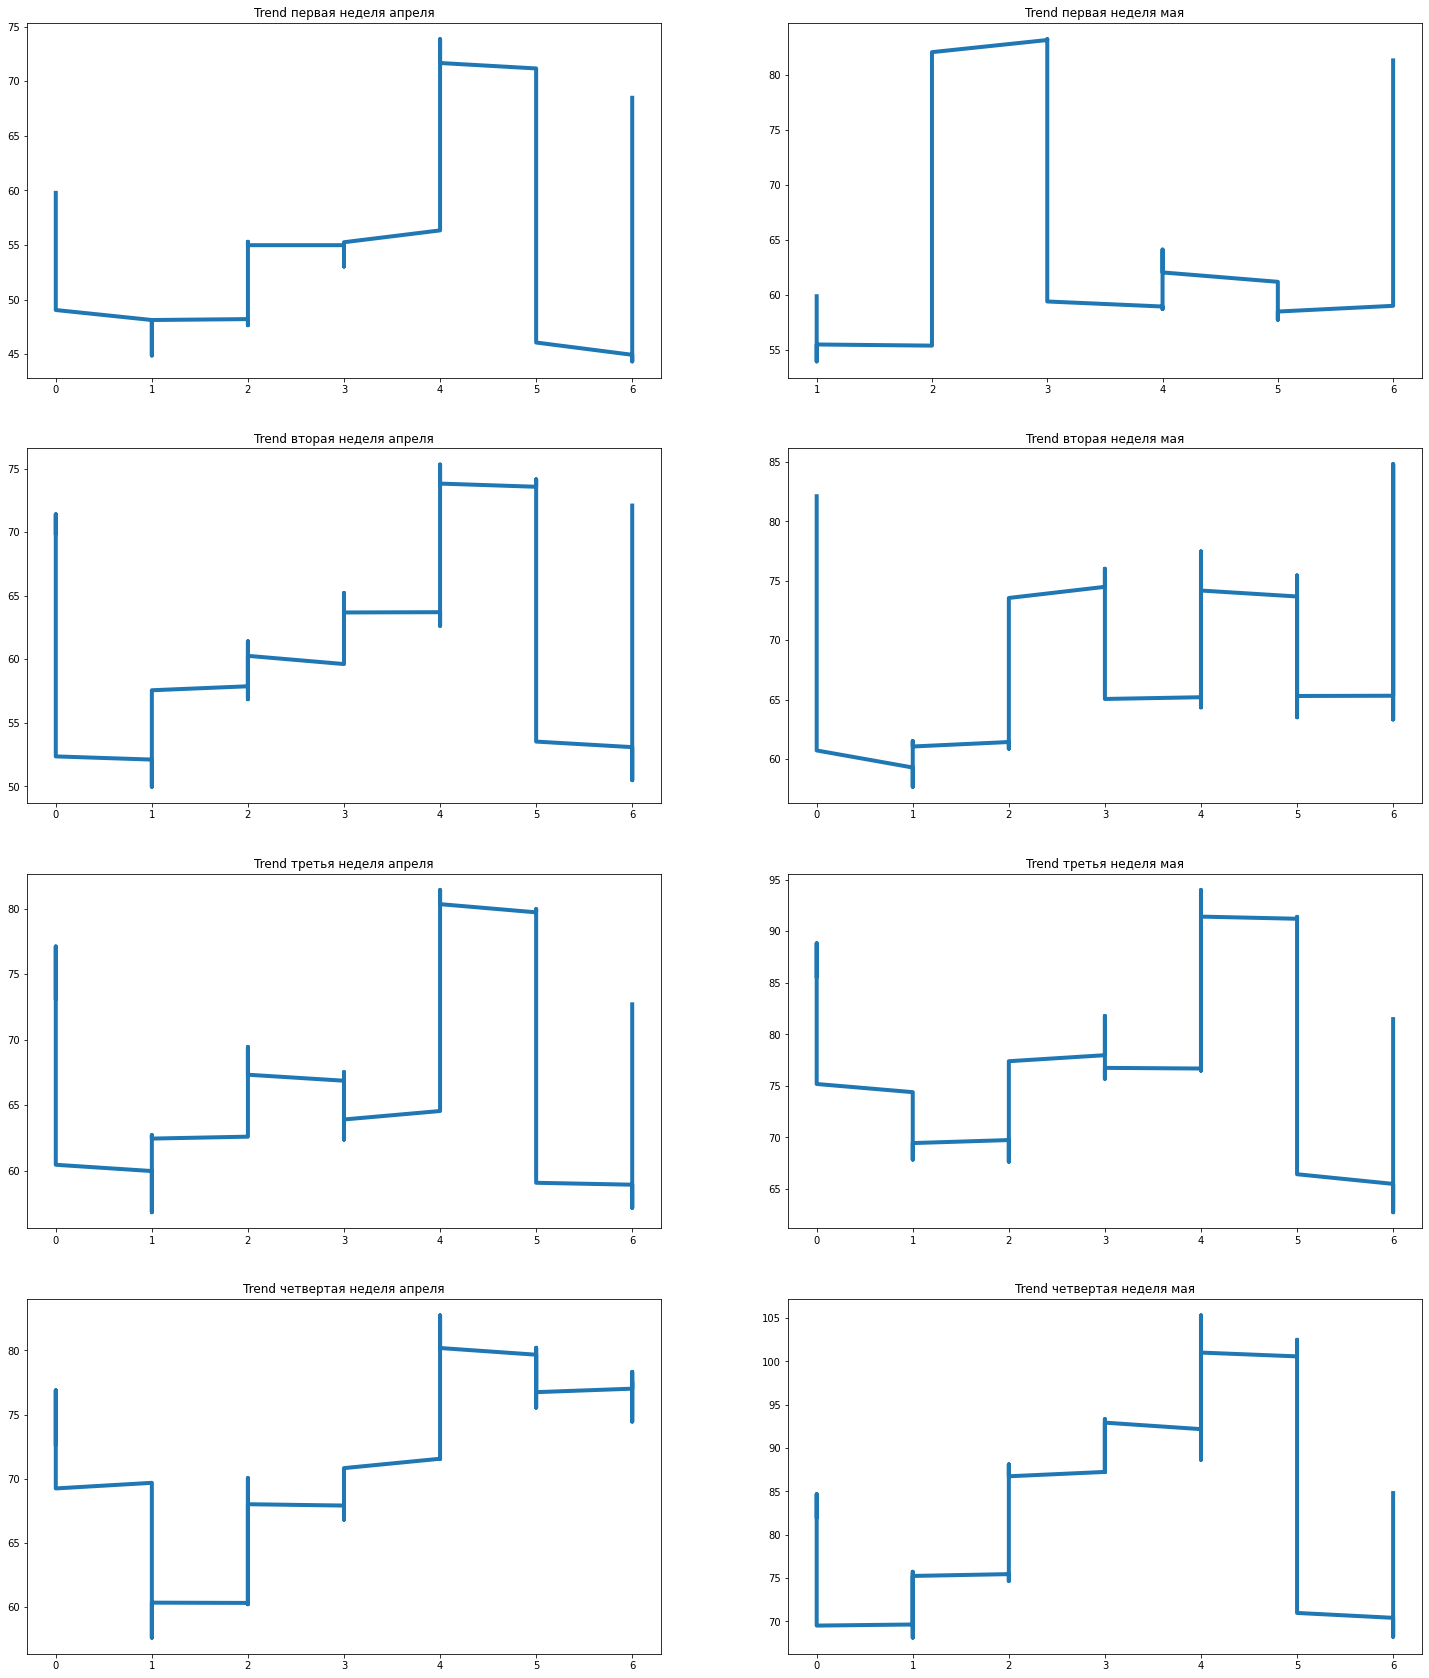

In [21]:
decomposed_short = seasonal_decompose(df['2018-04-02':'2018-05-31']['num_orders'])
fig2,ax2 = plt.subplots(4,2,figsize = (25,30))

ax2[0][0].plot(decomposed_short.trend['2018-04-02':'2018-04-08'].index.dayofweek,
            decomposed_short.trend['2018-04-02':'2018-04-08'].values,linewidth=4)
ax2[0][0].set_title('Trend первая неделя апреля')

ax2[1][0].plot(decomposed_short.trend['2018-04-09':'2018-04-15'].index.dayofweek,
            decomposed_short.trend['2018-04-09':'2018-04-15'].values,linewidth=4)
ax2[1][0].set_title('Trend вторая неделя апреля')

ax2[2][0].plot(decomposed_short.trend['2018-04-16':'2018-04-22'].index.dayofweek,
            decomposed_short.trend['2018-04-16':'2018-04-22'].values,linewidth=4)
ax2[2][0].set_title('Trend третья неделя апреля')

ax2[3][0].plot(decomposed_short.trend['2018-04-23':'2018-04-29'].index.dayofweek,
            decomposed_short.trend['2018-04-23':'2018-04-29'].values,linewidth=4)
ax2[3][0].set_title('Trend четвертая неделя апреля')


ax2[0][1].plot(decomposed_short.trend['2018-05-01':'2018-05-06'].index.dayofweek,
            decomposed_short.trend['2018-05-01':'2018-05-06'].values,linewidth=4)
ax2[0][1].set_title('Trend первая неделя мая')

ax2[1][1].plot(decomposed_short.trend['2018-05-07':'2018-05-13'].index.dayofweek,
            decomposed_short.trend['2018-05-07':'2018-05-13'].values,linewidth=4)
ax2[1][1].set_title('Trend вторая неделя мая')

ax2[2][1].plot(decomposed_short.trend['2018-05-14':'2018-05-20'].index.dayofweek,
            decomposed_short.trend['2018-05-14':'2018-05-20'].values,linewidth=4)
ax2[2][1].set_title('Trend третья неделя мая')

ax2[3][1].plot(decomposed_short.trend['2018-05-21':'2018-05-27'].index.dayofweek,
            decomposed_short.trend['2018-05-21':'2018-05-27'].values,linewidth=4)
ax2[3][1].set_title('Trend четвертая неделя мая')

plt.show()

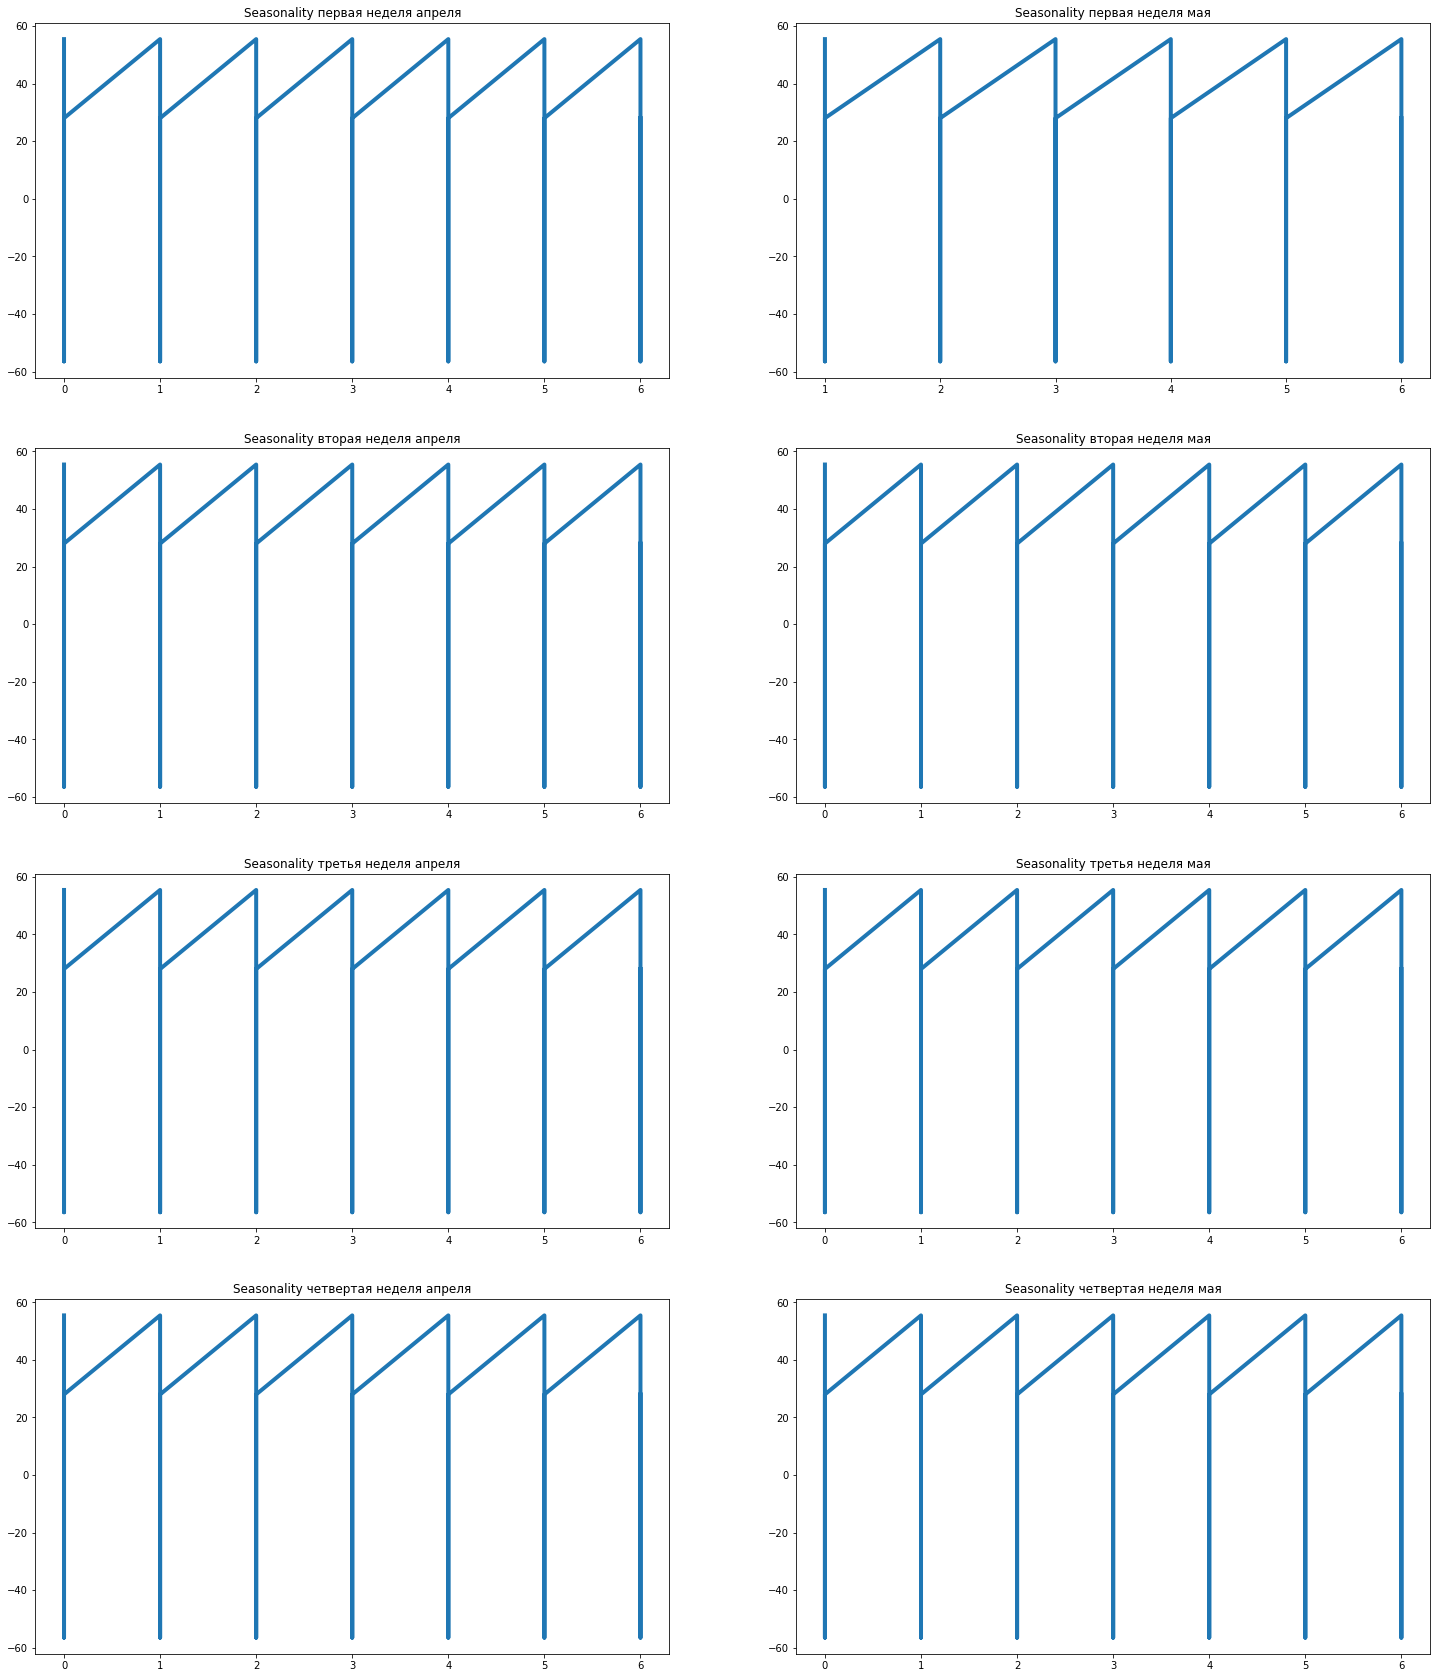

In [22]:
decomposed_short = seasonal_decompose(df['2018-04-02':'2018-05-31']['num_orders'])
fig2,ax2 = plt.subplots(4,2,figsize = (25,30))

ax2[0][0].plot(decomposed_short.seasonal['2018-04-02':'2018-04-08'].index.dayofweek,
            decomposed_short.seasonal['2018-04-02':'2018-04-08'].values,linewidth=4)
ax2[0][0].set_title('Seasonality первая неделя апреля')

ax2[1][0].plot(decomposed_short.seasonal['2018-04-09':'2018-04-15'].index.dayofweek,
            decomposed_short.seasonal['2018-04-09':'2018-04-15'].values,linewidth=4)
ax2[1][0].set_title('Seasonality вторая неделя апреля')

ax2[2][0].plot(decomposed_short.seasonal['2018-04-16':'2018-04-22'].index.dayofweek,
            decomposed_short.seasonal['2018-04-16':'2018-04-22'].values,linewidth=4)
ax2[2][0].set_title('Seasonality третья неделя апреля')

ax2[3][0].plot(decomposed_short.seasonal['2018-04-23':'2018-04-29'].index.dayofweek,
            decomposed_short.seasonal['2018-04-23':'2018-04-29'].values,linewidth=4)
ax2[3][0].set_title('Seasonality четвертая неделя апреля')


ax2[0][1].plot(decomposed_short.seasonal['2018-05-01':'2018-05-06'].index.dayofweek,
            decomposed_short.seasonal['2018-05-01':'2018-05-06'].values,linewidth=4)
ax2[0][1].set_title('Seasonality первая неделя мая')

ax2[1][1].plot(decomposed_short.seasonal['2018-05-07':'2018-05-13'].index.dayofweek,
            decomposed_short.seasonal['2018-05-07':'2018-05-13'].values,linewidth=4)
ax2[1][1].set_title('Seasonality вторая неделя мая')

ax2[2][1].plot(decomposed_short.seasonal['2018-05-14':'2018-05-20'].index.dayofweek,
            decomposed_short.seasonal['2018-05-14':'2018-05-20'].values,linewidth=4)
ax2[2][1].set_title('Seasonality третья неделя мая')

ax2[3][1].plot(decomposed_short.seasonal['2018-05-21':'2018-05-27'].index.dayofweek,
            decomposed_short.seasonal['2018-05-21':'2018-05-27'].values,linewidth=4)
ax2[3][1].set_title('Seasonality четвертая неделя мая')

plt.show()

Видим пик заказов в начале каждого дня, затем к утру резкое падение и к вечеру количество заказов снова растет и достигает нового пика. Также можно заметить тренд на рост заказов во второй половине недели.

Проверим, является ли временной ряд стационарным

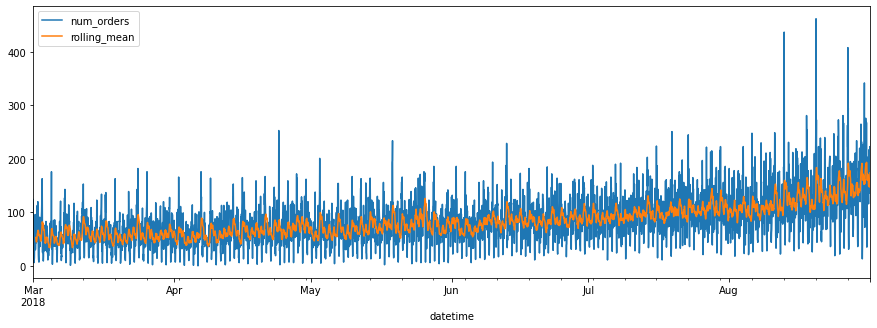

In [23]:
show_hist(df)

In [24]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Ряд стационарный


Временной ряд стационарный, посмотрим измениться ли ситуация, если получить разность временного ряда

In [25]:
df_before_shift = df.copy()
df_after_shift = df.copy()

In [26]:
df_after_shift = df - df.shift()

In [27]:
df_after_shift["rolling_mean"] = df_after_shift["num_orders"].rolling(15).mean()
df_after_shift["rolling_std"] = df_after_shift["num_orders"].rolling(15).std()

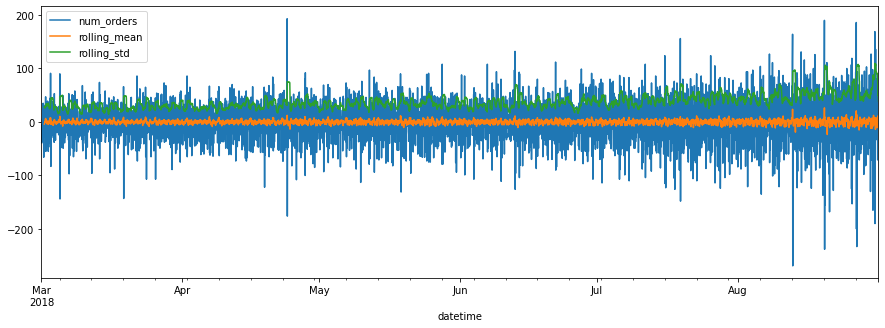

In [28]:
show_hist(df_after_shift)

In [29]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('Ряд стационарный')
else:
    print('Ряд нестационарный')

Ряд стационарный


### Вывод

- с мая идет плавное изменение среднего значения ряда;
- сезонность остается неизменной на протяжении всего исследуемого периода;
- наблюдается пик заказов в начале каждого дня, затем к утру резкое падение и к вечеру количество заказов снова растет и достигает нового пика; 
- также наблюдается тренд на рост заказов во второй половине недели.
- временной ряд стационарный.

## Обучение

Обучим модели:
- `RandomForestRegressor`;
- `DecisionTreeRegressor`;
- `LinearRegression`;
- `CatBoostRegressor`;
- `LGBMRegressor`;
- `XGBRegressor`.

Создадим датафрейм `df_results` для внесения результатов:

- `model_name` - наименование модели
- `rmse_model` - качество предсказания;
- `time_predict` - скорость предсказания в милисекундах;
- `time_fit` - время обучения в милисекундах.

In [30]:
column_names = ['model_name', 'time_fit', 'time_predict', 'rmse_model']
df_results = pd.DataFrame(columns = column_names)
display(df_results)

,model_name,time_fit,time_predict,rmse_model


In [31]:
def update_results(model_name, time_fit, time_predict, rmse_model, df_results):
    """функция обновления датафрейма с результатами"""
    resultRowStr= [model_name, time_fit, time_predict, rmse_model]
    rows = [pd.Series(resultRowStr, index=df_results.columns)]
    df_results=df_results.append(rows,ignore_index=True)
    return(df_results)

In [32]:
def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mean_squared_error(target, 
                                      predicted))
rmse_scoring = make_scorer(rmse_scorer,
                           greater_is_better=False)

In [33]:
def fit_models(model, features_train, target_train, features_test, target_test):
    """функция обучения и предсказания моделей с регистрацией затраченного времени"""
    start_fit = time.time()
    model.fit(features_train, target_train)
    time_fit = time.time() - start_fit

    start_predict = time.time()
    predicted_test = model.predict(features_test)
    time_predict = time.time() - start_predict

    rmse_model = rmse_scorer(target_test, predicted_test) 

    return(rmse_model,
           time_fit * 1000,
           time_predict * 1000)

In [34]:
splits = TimeSeriesSplit(n_splits=3)

### Подготовим признаки

Удалим признаки, которые использовались для анализа и создадим новые.

In [35]:
df_new = df_before_shift.drop('rolling_mean', axis=1)

In [36]:
def make_features(data, column, max_lag, rolling_mean_size):

    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [37]:
make_features(df_new, 'num_orders', 24, 20)

In [38]:
def split_data(df):
    """функция для формирования обучающей, валидационной и тестовой выборок"""
    (train, test) = train_test_split(df, shuffle=False, test_size = TEST_SIZE, random_state=12345)
    return (train, test)

In [39]:
(train,
 test) = split_data(df_new)

In [40]:
train = train.dropna()

In [41]:
(train_features,
 test_features) = (train.drop('num_orders',axis = 1),
                   test.drop('num_orders',axis = 1))
(train_target,
 test_target) = (train['num_orders'],
                 test['num_orders'])

In [42]:
print(train_features.shape)
print(train_target.shape)

(3950, 29)
(3950,)


In [43]:
print(test_features.shape)
print(test_target.shape)

(442, 29)
(442,)


### `RandomForestRegressor`

In [44]:
model_rfr = RandomForestRegressor()

In [45]:
parametrs_rfr = {'n_estimators':[10,50,100], 
                 'max_depth':range(1,10),
                'random_state':[STATE]} 

In [46]:
grid_rfr = GridSearchCV(model_rfr, 
                        parametrs_rfr,
                        scoring=rmse_scoring,
                        cv=splits,
                        verbose=True,
                        n_jobs=-1)

In [47]:
grid_rfr.fit(train_features, train_target)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': [10, 50, 100],
                         'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False),
             verbose=True)

In [48]:
print('Лучшие параметры модели RandomForestRegressor - {}'.format(grid_rfr.best_params_))

Лучшие параметры модели RandomForestRegressor - {'max_depth': 9, 'n_estimators': 100, 'random_state': 12345}


In [49]:
model_rfr = RandomForestRegressor(max_depth=9, 
                                  n_estimators=100, 
                                  random_state=STATE)

In [50]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_rfr,
                            train_features, 
                            train_target,
                            test_features,
                            test_target)

In [51]:
model_name = 'RandomForestRegressor'

In [52]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,RandomForestRegressor,2571.147203,10.240316,45.074945


### `DecisionTreeRegressor`

In [53]:
model_dfr = DecisionTreeRegressor()

In [54]:
parametrs_dfr = {'max_depth':range(1,10),
                'random_state':[STATE]} 

In [55]:
grid_dfr = GridSearchCV(model_dfr, 
                        parametrs_dfr,
                        scoring=rmse_scoring,
                        cv=splits,
                        verbose=True,
                        n_jobs=-1)

In [56]:
grid_dfr.fit(train_features, train_target)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10), 'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False),
             verbose=True)

In [57]:
print('Лучшие параметры модели DecisionTreeRegressor - {}'.format(grid_dfr.best_params_))

Лучшие параметры модели DecisionTreeRegressor - {'max_depth': 6, 'random_state': 12345}


In [58]:
model_dfr = DecisionTreeRegressor(max_depth=6, 
                                  random_state=STATE)

In [59]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_dfr,
                            train_features, 
                            train_target,
                            test_features,
                            test_target)

In [60]:
model_name = 'DecisionTreeRegressor'

In [61]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,RandomForestRegressor,2571.147203,10.240316,45.074945
1,DecisionTreeRegressor,32.275200,0.997305,63.352373


### `LinearRegression`

In [62]:
model_lr = LinearRegression()

In [63]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_lr,
                            train_features, 
                            train_target,
                            test_features,
                            test_target)

In [64]:
model_name = 'LinearRegression'

In [65]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,RandomForestRegressor,2571.147203,10.240316,45.074945
1,DecisionTreeRegressor,32.275200,0.997305,63.352373
2,LinearRegression,5.131960,0.997066,45.810949


### `CatBoostRegressor`

In [66]:
model_cbr = CatBoostRegressor()

In [67]:
parameters_cbr = {'depth':range(6,10),
                  'learning_rate':[0.1,0.5],
                  'metric_period':[10],
                  'random_state':[STATE]} 

In [68]:
grid_cbr = GridSearchCV(estimator=model_cbr, 
                        param_grid=parameters_cbr, 
                        scoring=rmse_scoring, 
                        cv=splits, 
                        n_jobs=-1, 
                        verbose=1)

In [69]:
grid_cbr.fit(train_features, train_target)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
0:	learn: 36.9394421	total: 180ms	remaining: 3m
10:	learn: 26.6875720	total: 219ms	remaining: 19.6s
20:	learn: 23.6102418	total: 256ms	remaining: 12s
30:	learn: 22.0990899	total: 291ms	remaining: 9.08s
40:	learn: 21.3750925	total: 321ms	remaining: 7.51s
50:	learn: 20.9538995	total: 350ms	remaining: 6.51s
60:	learn: 20.3489225	total: 380ms	remaining: 5.85s
70:	learn: 19.7810237	total: 415ms	remaining: 5.42s
80:	learn: 19.1694542	total: 450ms	remaining: 5.11s
90:	learn: 18.7264894	total: 484ms	remaining: 4.83s
100:	learn: 18.2572943	total: 518ms	remaining: 4.61s
110:	learn: 17.8460213	total: 553ms	remaining: 4.43s
120:	learn: 17.4720514	total: 588ms	remaining: 4.27s
130:	learn: 17.0393642	total: 622ms	remaining: 4.13s
140:	learn: 16.6096172	total: 661ms	remaining: 4.03s
150:	learn: 16.2358575	total: 696ms	remaining: 3.91s
160:	learn: 15.8316110	total: 731ms	remaining: 3.81s
170:	learn: 15.5052177	total: 766ms	remaining: 3.71s
18

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000020693214880>,
             n_jobs=-1,
             param_grid={'depth': range(6, 10), 'learning_rate': [0.1, 0.5],
                         'metric_period': [10], 'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False),
             verbose=1)

In [70]:
print('Лучшие параметры модели CatBoostRegressor - {}'.format(grid_cbr.best_params_))

Лучшие параметры модели CatBoostRegressor - {'depth': 7, 'learning_rate': 0.1, 'metric_period': 10, 'random_state': 12345}


In [71]:
model_cbr = CatBoostRegressor(depth=8,
                              learning_rate=0.1,
                              metric_period=10,
                              random_state=STATE) 

In [72]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_cbr,
                            train_features, 
                            train_target,
                            test_features,
                            test_target)

0:	learn: 36.9737571	total: 8.35ms	remaining: 8.34s
10:	learn: 26.6629410	total: 75.3ms	remaining: 6.77s
20:	learn: 22.9896557	total: 139ms	remaining: 6.47s
30:	learn: 21.3202369	total: 216ms	remaining: 6.75s
40:	learn: 20.6243332	total: 273ms	remaining: 6.38s
50:	learn: 19.6630275	total: 336ms	remaining: 6.25s
60:	learn: 19.2125764	total: 399ms	remaining: 6.15s
70:	learn: 18.8094787	total: 466ms	remaining: 6.1s
80:	learn: 18.3324931	total: 532ms	remaining: 6.03s
90:	learn: 17.8073647	total: 594ms	remaining: 5.93s
100:	learn: 17.4387949	total: 656ms	remaining: 5.83s
110:	learn: 16.7453870	total: 724ms	remaining: 5.8s
120:	learn: 16.2533862	total: 787ms	remaining: 5.71s
130:	learn: 15.6689066	total: 848ms	remaining: 5.63s
140:	learn: 15.1365382	total: 909ms	remaining: 5.54s
150:	learn: 14.7436721	total: 974ms	remaining: 5.48s
160:	learn: 14.2574132	total: 1.06s	remaining: 5.53s
170:	learn: 13.8845435	total: 1.13s	remaining: 5.47s
180:	learn: 13.5527770	total: 1.21s	remaining: 5.46s
190:

In [73]:
model_name = 'CatBoostRegressor'

In [74]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,RandomForestRegressor,2571.147203,10.240316,45.074945
1,DecisionTreeRegressor,32.275200,0.997305,63.352373
2,LinearRegression,5.131960,0.997066,45.810949
3,CatBoostRegressor,6920.727968,3.140926,41.511541


### `LGBMRegressor`

In [75]:
model_lgbmr = LGBMRegressor()

In [76]:
parameters_lgbmr = {'num_leaves':[60],
                    'learning_rate':[0.1,0.5],
                    'max_depth':[6,10],
                    'random_state':[STATE]}

In [77]:
grid_lgbmr = GridSearchCV(estimator=model_lgbmr, 
                          param_grid=parameters_lgbmr, 
                          scoring=rmse_scoring, 
                          cv=splits, 
                          n_jobs=-1)

In [78]:
grid_lgbmr.fit(train_features, train_target) 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [6, 10],
                         'num_leaves': [60], 'random_state': [12345]},
             scoring=make_scorer(rmse_scorer, greater_is_better=False))

In [79]:
print('Лучшие параметры модели LGBMRegressor - {}'.format(grid_lgbmr.best_params_))

Лучшие параметры модели LGBMRegressor - {'learning_rate': 0.1, 'max_depth': 6, 'num_leaves': 60, 'random_state': 12345}


In [80]:
model_lgbmr = LGBMRegressor(learning_rate=0.1,
                            max_depth=6,
                            num_leaves=60,
                            random_state=STATE)

In [81]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_lgbmr,
                            train_features, 
                            train_target,
                            test_features,
                            test_target)

In [82]:
model_name = 'LGBMRegressor'

In [83]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,RandomForestRegressor,2571.147203,10.240316,45.074945
1,DecisionTreeRegressor,32.275200,0.997305,63.352373
2,LinearRegression,5.131960,0.997066,45.810949
3,CatBoostRegressor,6920.727968,3.140926,41.511541
4,LGBMRegressor,99.245548,2.988577,39.472270


### `XGBRegressor`

In [84]:
model_xgbr = XGBRegressor()

In [85]:
parameters_xgbr = {'learning_rate':[0.1,0.5],
                   'max_depth':[6,12],
                   'subsample':[0.5],
                   'colsample_bytree':[0.5],
                   'random_state':[STATE]}

In [86]:
grid_xgbr = GridSearchCV(estimator=model_xgbr,
                         param_grid=parameters_xgbr,
                         scoring=rmse_scoring,
                         cv=splits,
                         n_jobs=-1,
                         verbose=1)

In [87]:
grid_xgbr.fit(train_features, train_target)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    i...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [88]:
print('Лучшие параметры модели XGBRegressor - {}'.format(grid_xgbr.best_params_))

Лучшие параметры модели XGBRegressor - {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 12345, 'subsample': 0.5}


In [89]:
model_xgbr = XGBRegressor(colsample_bytre=0.5,
                          learning_rate=0.1,
                          max_depth=6,
                          random_state=STATE,
                          subsample=0.5)

In [90]:
(rmse_model,
 time_fit, 
 time_predict) = fit_models(model_xgbr,
                            train_features, 
                            train_target,
                            test_features,
                            test_target)

[20:09:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytre" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [91]:
model_name = 'XGBRegressor'

In [92]:
df_results = update_results(model_name, time_fit, time_predict, rmse_model, df_results)
df_results

,model_name,time_fit,time_predict,rmse_model
0,RandomForestRegressor,2571.147203,10.240316,45.074945
1,DecisionTreeRegressor,32.275200,0.997305,63.352373
2,LinearRegression,5.131960,0.997066,45.810949
3,CatBoostRegressor,6920.727968,3.140926,41.511541
4,LGBMRegressor,99.245548,2.988577,39.472270
5,XGBRegressor,268.840790,3.988504,46.751181


### Вывод

Лучшая модель по результату скорости обучения и предсказания:
- `LinearRegression`

In [117]:
model_lr

LinearRegression()

In [118]:
predicted_lr = model_lr.predict(test_features)

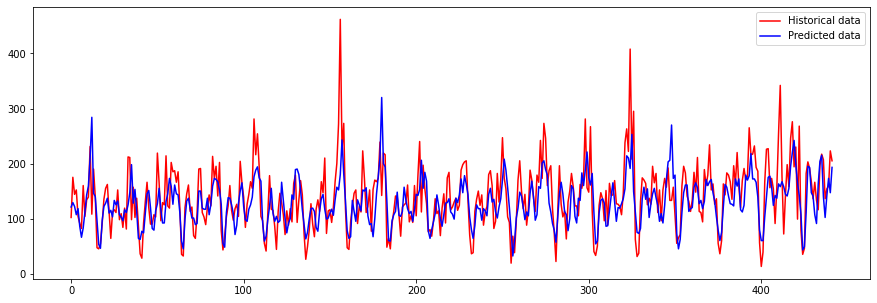

In [119]:
visual_of_predictions(test_target, predicted_lr)

Лучшая модель по результату среднеквадратичной ошибки `RMSE`:
- `LGBMRegressor`

In [100]:
model_lgbmr

LGBMRegressor(max_depth=6, num_leaves=60, random_state=12345)

In [122]:
predicted_lgbmr = model_lgbmr.predict(test_features)

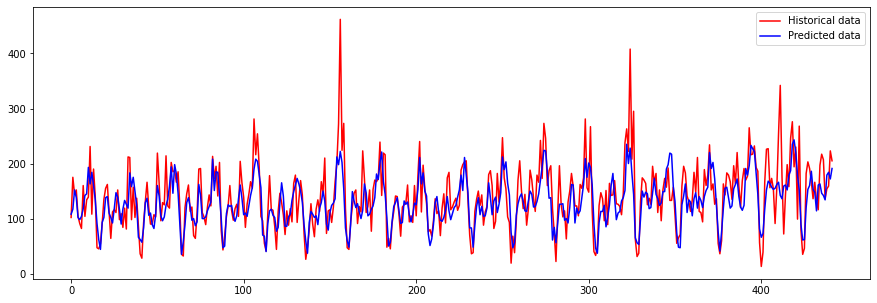

In [123]:
visual_of_predictions(test_target, predicted_lgbmr)

## Общий вывод

1. С исходным набором данных проведена сл. работа:
- тип данных столбца `datetime` приведен к типу `datetime64[ns]`;
- выполнено ресемплирование по одному часу;
- выполнено сглаживание временного ряда методом скользящего среднего. 

В целом данные чистые - не содержат пропущенных значений и дубликатов. Набор данных показывает данные о заказах в период с `2018-03-01 00:00:00` по `2018-08-31 23:50:00`. Также отметим, что в данных:

- с мая идет плавное изменение среднего значения ряда;
- сезонность остается неизменной на протяжении всего исследуемого периода;
- наблюдается пик заказов в начале каждого дня, затем к утру резкое падение и к вечеру количество заказов снова растет и достигает нового пика; 
- также наблюдается тренд на рост заказов во второй половине недели.
- временной ряд стационарный.

2. Обучены модели:
- `RandomForestRegressor`;
- `DecisionTreeRegressor`;
- `LinearRegression`;
- `CatBoostRegressor`;
- `LGBMRegressor`;
- `XGBRegressor`.

Лучшая модель по результату скорости обучения и предсказания:
- `LinearRegression`.

Лучшая модель по результату среднеквадратичной ошибки `RMSE`:
- `LGBMRegressor`.